**Importing modules and libraries**

In [24]:
%pip install nltk
import pandas as pd
import matplotlib.pyplot as plt
import re
import warnings
import numpy as np
import nltk
#nltk.download('all')
from sklearn.preprocessing import normalize
from sklearn.feature_extraction.text import CountVectorizer
import seaborn as sns
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score, log_loss
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import SGDClassifier
from collections import Counter
from scipy.sparse import hstack
from collections import defaultdict
from sklearn.model_selection import train_test_split
import math
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.calibration import CalibratedClassifierCV

# downloading text processing libraries
nltk.download('stopwords')
nltk.download('punkt')

from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize

DEPRECATION: Loading egg at c:\users\prithu misra\lib\site-packages\vboxapi-1.0-py3.11.egg is deprecated. pip 24.3 will enforce this behaviour change. A possible replacement is to use pip for package installation.. Discussion can be found at https://github.com/pypa/pip/issues/12330

[notice] A new release of pip is available: 24.0 -> 24.2
[notice] To update, run: python.exe -m pip install --upgrade pip
[nltk_data] Downloading package stopwords to C:\Users\PRITHU
[nltk_data]     MISRA\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to C:\Users\PRITHU
[nltk_data]     MISRA\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


**TRAINING-VARIANTS**

In [25]:
data = pd.read_csv('./training_variants.txt')
print('Total number of data points: ', data.shape[0])
print('Total number of features: ', data.shape[1])
print('List of features: ', data.columns.values)
print ('The first five data points are:')
print (data.head())
print (data.dtypes)
print('Number of unique variations:', len(data['Variation'].unique()))
print ('Number of unique genes:', len(data['Gene'].unique()))

Total number of data points:  3321
Total number of features:  4
List of features:  ['ID' 'Gene' 'Variation' 'Class']
The first five data points are:
   ID    Gene             Variation  Class
0   0  FAM58A  Truncating Mutations      1
1   1     CBL                 W802*      2
2   2     CBL                 Q249E      2
3   3     CBL                 N454D      3
4   4     CBL                 L399V      4
ID            int64
Gene         object
Variation    object
Class         int64
dtype: object
Number of unique variations: 2996
Number of unique genes: 264


**CLINICAL-INFO**

In [26]:
text_data = pd.read_csv("./clinical_info.txt",sep="\|\|",names=["ID","Text"],skiprows=1)
print('Number of data points: ', text_data.shape[0])
print('Number of features: ', text_data.shape[1])
print('Features: ', text_data.columns.values)
print(text_data.head())

C:\Users\PRITHU MISRA\AppData\Local\Temp\ipykernel_21084\3907512518.py:1: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  text_data = pd.read_csv("./clinical_info.txt",sep="\|\|",names=["ID","Text"],skiprows=1)


Number of data points:  500
Number of features:  2
Features:  ['ID' 'Text']
   ID                                               Text
0   0  Cyclin-dependent kinases (CDKs) regulate a var...
1   1   Abstract Background  Non-small cell lung canc...
2   2   Abstract Background  Non-small cell lung canc...
3   3  Recent evidence has demonstrated that acquired...
4   4  Oncogenic mutations in the monomeric Casitas B...


**Cleaning and Preprocessing**
1. Replace special characters with ''.

2. Replace multiple spaces with a single space.

3. Convert the entire text to lowercase.

4. Tokenize the text into words.

5. Create a list of tokenized words that are not stopwords.

6. Lastly, return the text as a string of those words separated by spaces.

In [27]:
#Chicking if the given text is a string , proceed further only if its a string
stop_words = set(stopwords.words('english'))

def text_preprocess(text):
    if isinstance(text, str):
        text = re.sub('[^a-zA-Z0-9\n]', ' ', text)
        text = re.sub('\s+',' ', text)
        text = text.lower()
        words = word_tokenize(text)
        final_words = [word for word in words if word not in stop_words]
        final_text = ' '.join(final_words)
        return final_text

**Now we will use the text pre_precess function to clear the clinical_info dataset since it contains lots of redundant data**

In [28]:
for idx, data_point in text_data.iterrows():
    if isinstance(data_point['Text'], str):
        text_data.loc[idx,'Text'] = text_preprocess(data_point['Text'])
    else:
        print("Corresponding text data missing for data point number:", idx)

In [29]:
final_df = pd.merge(data, text_data, on='ID', how='left')
final_df['Text'] = final_df['Text'].fillna(final_df['Gene'] + ' ' + final_df['Variation'])
final_df['Gene'] = final_df['Gene'].str.replace('\s+', '_')
final_df['Variation'] = final_df['Variation'].str.replace('\s+', '_')

**SPLITTING - TRAIN - TEST - DATA**

In [30]:
# Split the data into test and train sets while maintaining the same distribution of the 'Class' column
init_train_df, test_df = train_test_split(final_df, test_size=0.2, stratify=final_df['Class'])

# Split the train data into train and cross-validation sets while maintaining the same distribution of the 'Class' column
train_df, cv_df = train_test_split(init_train_df, test_size=0.2, stratify=init_train_df['Class'])

# Extract the target variables
y_train = train_df['Class'].values
y_cv = cv_df['Class'].values
y_test = test_df['Class'].values

# Drop the 'Class' column from the datasets
x_train = train_df.drop(columns=['Class'])
x_cv = cv_df.drop(columns=['Class'])
x_test = test_df.drop(columns=['Class'])

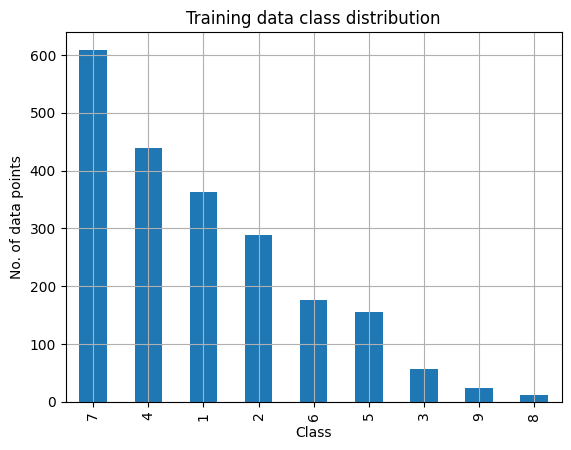

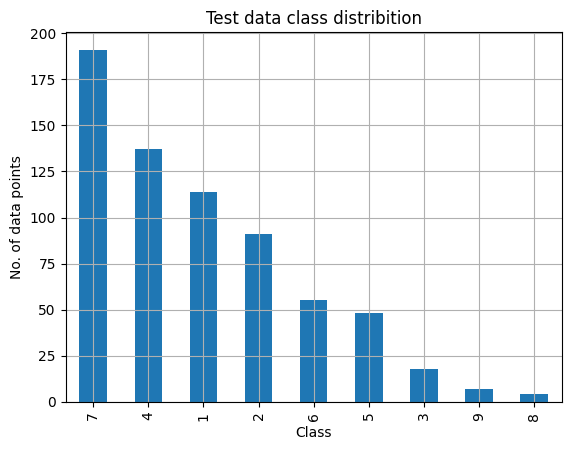

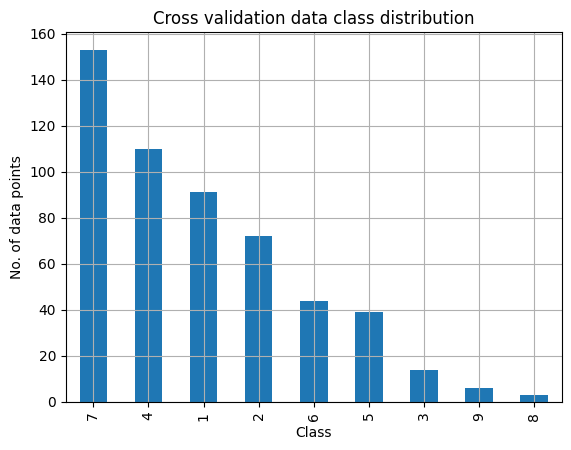

In [31]:
def plot_distribution(data_distribution, title):
    data_distribution.plot(kind='bar')
    plt.xlabel('Class')
    plt.ylabel('No. of data points')
    plt.title(title)
    plt.grid()
    plt.show()


train_class_distribution = train_df['Class'].value_counts()
test_class_distribution = test_df['Class'].value_counts()
cv_class_distribution = cv_df['Class'].value_counts()

plot_distribution(train_class_distribution, 'Training data class distribution')
plot_distribution(test_class_distribution, 'Test data class distribition')
plot_distribution(cv_class_distribution, 'Cross validation data class distribution')

In [32]:
def plot_heatmap(matrix, labels, title):
    plt.figure()
    sns.heatmap(matrix, annot=True, xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.title(title)
    plt.show()


def plot_confusion_matrix(test_y, predict_y):
    C = confusion_matrix(test_y, predict_y)
    labels = [1, 2, 3, 4, 5, 6, 7, 8, 9]

    # Calculate the recall matrix
    recall_matrix = C / C.sum(axis=1, keepdims=True)

    # Calculate the precision matrix
    precision_matrix = C / C.sum(axis=0, keepdims=True)

    # Plot the confusion matrix
    plot_heatmap(C, labels, "Confusion matrix")

    # Plot the precision matrix
    plot_heatmap(precision_matrix, labels, "Precision matrix (sum of elements in a column=1)")

    # Plot the recall matrix
    plot_heatmap(recall_matrix, labels, "Recall matrix (sum of elements in a row=1)")

**Measure Metrics from a Dummy Baseline Model**

Log loss on Cross Validation Data using Random Model: 2.5014968592776565
Log loss on Test Data using Random Model: 2.4622419508208284
Performance matrices for test data


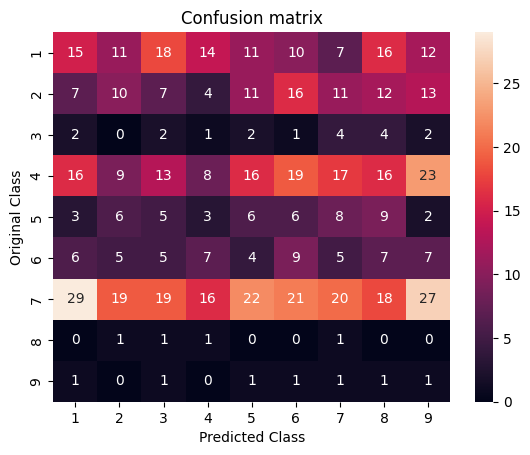

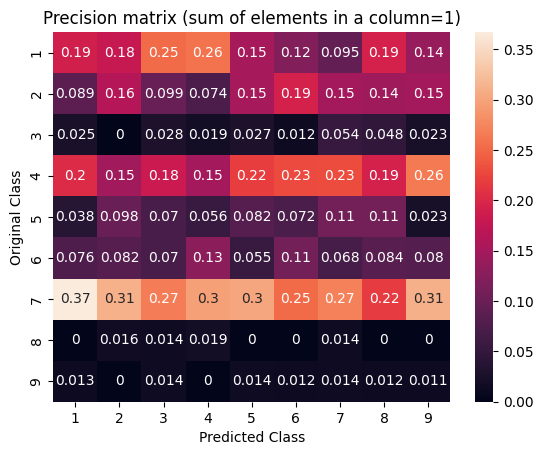

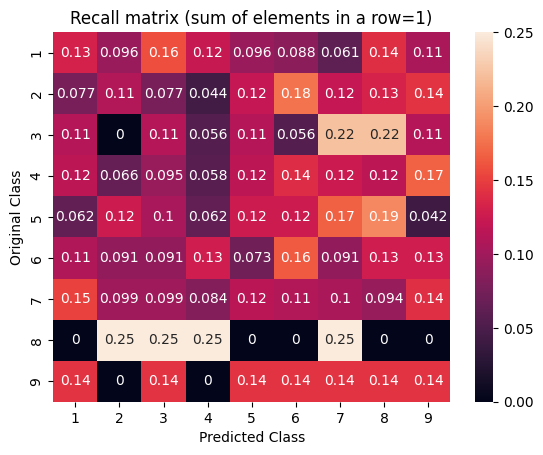

In [33]:
def generate_random_predictions(data_len):
    predicted_y = np.zeros((data_len, 9))
    for i in range(data_len):
        rand_probs = np.random.rand(1, 9)
        predicted_y[i] = rand_probs / rand_probs.sum()
    return predicted_y

cv_data_len = cv_df.shape[0]
test_data_len = test_df.shape[0]

# Generate random predictions for CV data
cv_predicted_y = generate_random_predictions(cv_data_len)
print("Log loss on Cross Validation Data using Random Model:", log_loss(y_cv, cv_predicted_y))

# Generate random predictions for test data
test_predicted_y = generate_random_predictions(test_data_len)
print("Log loss on Test Data using Random Model:", log_loss(y_test, test_predicted_y))

# Plot performance matrix for test data
predicted_y = np.argmax(test_predicted_y, axis=1)
print ("Performance matrices for test data")
plot_confusion_matrix(y_test, predicted_y + 1)

In [34]:
def extract_response_coding_probs(alpha, feature, df):
    total_classes = 9
    # Group the DataFrame by the feature and Class cloumns and get counts
    grouped = df.groupby([feature, 'Class']).size().reset_index(name='count')

    response_code_probs = {}
    feature_counts = df[feature].value_counts().to_dict()

    for value in feature_counts:
        value_group = grouped[grouped[feature] == value]
        class_probs = []
        for k in range(1, total_classes + 1):
            # Check if the current class exists for the current feature value
            if k in value_group['Class'].values:
                count = value_group[value_group['Class'] == k]['count'].values[0]
            else:
                count = 0

            numerator = count + alpha
            denominator = feature_counts[value] + total_classes * alpha
            class_probs.append(numerator / denominator)
        response_code_probs[value] = class_probs

    return response_code_probs

In [35]:
def generate_response_coded_feature(feature, df, response_code_probs):
    total_classes = 9
    default_prob = [1 / total_classes] * total_classes
    response_coded_feature = df[feature].map(lambda x: response_code_probs.get(x, default_prob))

    return response_coded_feature.tolist()

In [36]:
alpha = 1

gene_dict = extract_response_coding_probs(alpha, 'Gene', train_df)

train_gene_rc = np.array(generate_response_coded_feature("Gene", train_df, gene_dict))
test_gene_rc = np.array(generate_response_coded_feature("Gene", test_df, gene_dict))
cv_gene_rc = np.array(generate_response_coded_feature("Gene", cv_df, gene_dict))

variation_dict=extract_response_coding_probs(alpha, 'Variation', train_df)
train_variation_rc = np.array(generate_response_coded_feature("Variation", train_df, variation_dict))
test_variation_rc = np.array(generate_response_coded_feature("Variation", test_df, variation_dict))
cv_variation_rc = np.array(generate_response_coded_feature("Variation", cv_df, variation_dict))

In [37]:
def extract_counter(cls_text):
    all_words = cls_text['Text'].apply(lambda x: x.split()).explode().tolist()
    word_count = Counter(all_words)
    return word_count


In [38]:
dict_list = []
for i in range(1,10):
    cls_text = train_df[train_df['Class']==i]
    dict_list.append(extract_counter(cls_text))
total_dict = extract_counter(train_df)

In [39]:
def generate_text_responsecoding(df, dict_list, total_dict, alpha):
    num_classes = 9
    num_rows = df.shape[0] 

    text_feature_rc = np.zeros((num_rows, num_classes))

    df['split_text'] = df['Text'].apply(lambda x: x.split())

    for i in range(num_classes):
        row_index = 0
        for split_text in df['split_text']:
            sum_prob = sum(
                map(
                    lambda word: math.log((dict_list[i].get(word, 0) + alpha) / (total_dict.get(word, 0) + 9*alpha)),
                    split_text
                )
            )
            text_feature_rc[row_index, i] = math.exp(sum_prob / len(split_text))
            row_index += 1
 
            df.drop(['split_text'], axis=1)
           
    return text_feature_rc

In [40]:
alpha = 10

train_text_rc  = generate_text_responsecoding(train_df, dict_list, total_dict, alpha)
test_text_rc  = generate_text_responsecoding(test_df, dict_list, total_dict, alpha)
cv_text_rc  = generate_text_responsecoding(cv_df, dict_list, total_dict, alpha)

In [41]:
# One-hot encoding the Gene feature
gene_vectorizer = CountVectorizer()
train_gene_oh = gene_vectorizer.fit_transform(train_df['Gene'])
test_gene_oh = gene_vectorizer.transform(test_df['Gene'])
cv_gene_oh = gene_vectorizer.transform(cv_df['Gene'])

# One-hot encoding the Variation feature
variation_vectorizer = CountVectorizer()
train_variation_oh = variation_vectorizer.fit_transform(train_df['Variation'])
test_variation_oh = variation_vectorizer.transform(test_df['Variation'])
cv_variation_oh = variation_vectorizer.transform(cv_df['Variation'])

# One-hot encoding the Text feature
text_vectorizer = CountVectorizer(min_df=3)
train_text_oh = text_vectorizer.fit_transform(train_df['Text']) # A minimum degree of freedom 3 is used to ensure that extremely rare words are not included while training

test_text_oh = text_vectorizer.transform(test_df['Text'])
cv_text_oh = text_vectorizer.transform(cv_df['Text'])

In [42]:
train_text_oh = normalize(train_text_oh, axis=0)
test_text_oh = normalize(test_text_oh, axis=0)
cv_text_oh = normalize(cv_text_oh, axis=0)

train_text_rc = normalize(train_text_rc, axis=1, norm='l1')
test_text_rc = normalize(test_text_rc, axis=1, norm='l1')
cv_text_rc = normalize(cv_text_rc, axis=1, norm='l1')

In [43]:
gene_log_error_array = []
alpha = 0.0001

clf = SGDClassifier(alpha=alpha, penalty='l2', loss='log_loss', random_state=42)
clf.fit(train_gene_oh, y_train)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid", cv="prefit")
sig_clf.fit(cv_gene_oh, y_cv)
predict_array = sig_clf.predict_proba(cv_gene_oh)
gene_log_error=log_loss(y_cv, predict_array, labels=clf.classes_, eps=1e-15)
print (gene_log_error)

variation_log_error_array = []

clf = SGDClassifier(alpha=alpha, penalty='l2', loss='log_loss', random_state=42)
clf.fit(train_variation_oh, y_train)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid", cv="prefit")
sig_clf.fit(cv_variation_oh, y_cv)
predict_array = sig_clf.predict_proba(cv_variation_oh)
variation_log_error=log_loss(y_cv, predict_array, labels=clf.classes_, eps=1e-15)
print (variation_log_error)

text_log_error_array = []

clf = SGDClassifier(alpha=alpha, penalty='l2', loss='log_loss', random_state=42)
clf.fit(train_text_oh, y_train)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid", cv="prefit")
sig_clf.fit(cv_text_oh, y_cv)
predict_array = sig_clf.predict_proba(cv_text_oh)
text_log_error=log_loss(y_cv, predict_array, labels=clf.classes_, eps=1e-15)
print (text_log_error)

c:\Users\PRITHU MISRA\Lib\site-packages\sklearn\metrics\_classification.py:2910: FutureWarning: Setting the eps parameter is deprecated and will be removed in 1.5. Instead eps will always havea default value of `np.finfo(y_pred.dtype).eps`.
  warnings.warn(
c:\Users\PRITHU MISRA\Lib\site-packages\sklearn\metrics\_classification.py:2910: FutureWarning: Setting the eps parameter is deprecated and will be removed in 1.5. Instead eps will always havea default value of `np.finfo(y_pred.dtype).eps`.
  warnings.warn(


1.1344533831533359
1.6637688290065575
1.6894574770409754


c:\Users\PRITHU MISRA\Lib\site-packages\sklearn\metrics\_classification.py:2910: FutureWarning: Setting the eps parameter is deprecated and will be removed in 1.5. Instead eps will always havea default value of `np.finfo(y_pred.dtype).eps`.
  warnings.warn(


In [44]:
train_gene_var_oh = hstack((train_gene_oh, train_variation_oh))
test_gene_var_oh = hstack((test_gene_oh, test_variation_oh))
cv_gene_var_oh = hstack((cv_gene_oh, cv_variation_oh))

train_x_oh = hstack((train_gene_var_oh, train_text_oh)).tocsr()
test_x_oh = hstack((test_gene_var_oh, test_text_oh)).tocsr()
cv_x_oh = hstack((cv_gene_var_oh, cv_text_oh)).tocsr()

train_gene_var_rc = np.hstack((train_gene_rc, train_variation_rc))
test_gene_var_rc = np.hstack((test_gene_rc, test_variation_rc))
cv_gene_var_rc = np.hstack((cv_gene_rc, cv_variation_rc))

train_x_rc = np.hstack((train_gene_var_rc, train_text_rc))
test_x_rc = np.hstack((test_gene_var_rc, test_text_rc))
cv_x_rc = np.hstack((cv_gene_var_rc, cv_text_rc))

train_y = np.array(list(train_df['Class']))
test_y = np.array(list(test_df['Class']))
cv_y = np.array(list(cv_df['Class']))

**Train a Logistic Regression Model**

In [45]:
# Function to compute the log-loss for a range of alpha values
def compute_log_loss_for_alphas(train_x, train_y, cv_x, cv_y, alpha_range):
    log_error_array = []

    for alpha_value in alpha_range:
        print("for alpha =", alpha_value)


        classifier = SGDClassifier(class_weight='balanced', alpha=alpha_value, penalty='l2', loss='log_loss', random_state=42)
        classifier.fit(train_x, train_y)

    
        calibrated_classifier = CalibratedClassifierCV(classifier, method="sigmoid",cv="prefit")
        calibrated_classifier.fit(cv_x, cv_y)

       
        predicted_probs = calibrated_classifier.predict_proba(cv_x)
        log_loss_value = log_loss(cv_y, predicted_probs, labels=classifier.classes_, eps=1e-15)
        log_error_array.append(log_loss_value)

        print("Log Loss :", log_loss_value)

    return log_error_array


alpha_values = np.logspace(-4, 2, num=7, base=10).tolist()


cv_log_error_array = compute_log_loss_for_alphas(train_x_oh, train_y, cv_x_oh, cv_y, alpha_values)


best_alpha_index = np.argmin(cv_log_error_array)
best_alpha = alpha_values[best_alpha_index]
final_clf = SGDClassifier(class_weight='balanced', alpha=best_alpha, penalty='l2', loss='log_loss', random_state=42)
final_clf.fit(train_x_oh, train_y)


final_sig_clf = CalibratedClassifierCV(final_clf, method="sigmoid",cv="prefit")
final_sig_clf.fit(cv_x_oh, cv_y)

final_predictions = final_sig_clf.predict_proba(test_x_oh)
test_log_loss = log_loss(y_test, final_predictions, labels=final_clf.classes_, eps=1e-15)

print('For values of best alpha =', best_alpha, "The test log loss is:", test_log_loss)

for alpha = 0.0001


c:\Users\PRITHU MISRA\Lib\site-packages\sklearn\metrics\_classification.py:2910: FutureWarning: Setting the eps parameter is deprecated and will be removed in 1.5. Instead eps will always havea default value of `np.finfo(y_pred.dtype).eps`.
  warnings.warn(


Log Loss : 1.2328536125084986
for alpha = 0.001


c:\Users\PRITHU MISRA\Lib\site-packages\sklearn\metrics\_classification.py:2910: FutureWarning: Setting the eps parameter is deprecated and will be removed in 1.5. Instead eps will always havea default value of `np.finfo(y_pred.dtype).eps`.
  warnings.warn(


Log Loss : 1.1373837590331375
for alpha = 0.01


c:\Users\PRITHU MISRA\Lib\site-packages\sklearn\metrics\_classification.py:2910: FutureWarning: Setting the eps parameter is deprecated and will be removed in 1.5. Instead eps will always havea default value of `np.finfo(y_pred.dtype).eps`.
  warnings.warn(
c:\Users\PRITHU MISRA\Lib\site-packages\sklearn\metrics\_classification.py:2910: FutureWarning: Setting the eps parameter is deprecated and will be removed in 1.5. Instead eps will always havea default value of `np.finfo(y_pred.dtype).eps`.
  warnings.warn(


Log Loss : 1.3104282851333897
for alpha = 0.1
Log Loss : 1.6925284719688938
for alpha = 1.0


c:\Users\PRITHU MISRA\Lib\site-packages\sklearn\metrics\_classification.py:2910: FutureWarning: Setting the eps parameter is deprecated and will be removed in 1.5. Instead eps will always havea default value of `np.finfo(y_pred.dtype).eps`.
  warnings.warn(
c:\Users\PRITHU MISRA\Lib\site-packages\sklearn\metrics\_classification.py:2910: FutureWarning: Setting the eps parameter is deprecated and will be removed in 1.5. Instead eps will always havea default value of `np.finfo(y_pred.dtype).eps`.
  warnings.warn(


Log Loss : 1.7723890702079235
for alpha = 10.0
Log Loss : 1.7788057615389763
for alpha = 100.0
Log Loss : 1.7794646697977623
For values of best alpha = 0.001 The test log loss is: 1.2448436372749416


c:\Users\PRITHU MISRA\Lib\site-packages\sklearn\metrics\_classification.py:2910: FutureWarning: Setting the eps parameter is deprecated and will be removed in 1.5. Instead eps will always havea default value of `np.finfo(y_pred.dtype).eps`.
  warnings.warn(
c:\Users\PRITHU MISRA\Lib\site-packages\sklearn\metrics\_classification.py:2910: FutureWarning: Setting the eps parameter is deprecated and will be removed in 1.5. Instead eps will always havea default value of `np.finfo(y_pred.dtype).eps`.
  warnings.warn(


**Train a Random Forest Model**

In [46]:

def train_and_evaluate_model(train_x, train_y, cv_x, cv_y, n_estimators, max_depth):
    clf = RandomForestClassifier(n_estimators=n_estimators, criterion='gini', max_depth=max_depth, random_state=42, n_jobs=-1)
    clf.fit(train_x, train_y)
    sig_clf = CalibratedClassifierCV(clf, method="sigmoid", cv="prefit")
    sig_clf.fit(cv_x, cv_y)
    sig_clf_probs = sig_clf.predict_proba(cv_x)
    return log_loss(cv_y, sig_clf_probs, labels=clf.classes_)


alpha = [10, 50, 100, 200, 500, 1000]
max_depth = [2, 3, 5, 10]


param_grid = [(i, j) for i in alpha for j in max_depth]

log_errors = [train_and_evaluate_model(train_x_rc, train_y, cv_x_rc, cv_y, i, j) for i, j in param_grid]

min_log_error = min(log_errors)
best_params_index = log_errors.index(min_log_error)
best_alpha, best_max_depth = param_grid[best_params_index]

final_clf = RandomForestClassifier(n_estimators=best_alpha, criterion='gini', max_depth=best_max_depth, random_state=42, n_jobs=-1)
final_clf.fit(train_x_rc, train_y)
final_sig_clf = CalibratedClassifierCV(final_clf, method="sigmoid",cv="prefit")
final_sig_clf.fit(cv_x_rc, cv_y)


def evaluate_final_model(data_x, data_y, message):
    predict_y = final_sig_clf.predict_proba(data_x)
    print(f'For values of best alpha = {best_alpha}, best max depth = {best_max_depth}, {message} log loss is:', log_loss(data_y, predict_y, labels=final_clf.classes_, eps=1e-15))

evaluate_final_model(train_x_rc, y_train, 'train')
evaluate_final_model(cv_x_rc, y_cv, 'cross validation')
evaluate_final_model(test_x_rc, y_test, 'test')

For values of best alpha = 500, best max depth = 5, train log loss is: 0.14406070058430115
For values of best alpha = 500, best max depth = 5, cross validation log loss is: 1.0911983707467696
For values of best alpha = 500, best max depth = 5, test log loss is: 1.1767721231342492


c:\Users\PRITHU MISRA\Lib\site-packages\sklearn\metrics\_classification.py:2910: FutureWarning: Setting the eps parameter is deprecated and will be removed in 1.5. Instead eps will always havea default value of `np.finfo(y_pred.dtype).eps`.
  warnings.warn(
c:\Users\PRITHU MISRA\Lib\site-packages\sklearn\metrics\_classification.py:2910: FutureWarning: Setting the eps parameter is deprecated and will be removed in 1.5. Instead eps will always havea default value of `np.finfo(y_pred.dtype).eps`.
  warnings.warn(
c:\Users\PRITHU MISRA\Lib\site-packages\sklearn\metrics\_classification.py:2910: FutureWarning: Setting the eps parameter is deprecated and will be removed in 1.5. Instead eps will always havea default value of `np.finfo(y_pred.dtype).eps`.
  warnings.warn(
